In [1]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import math
import os
import warnings
from collections import OrderedDict
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

try:
    from scipy import stats
except Exception:  # pragma: no cover - SciPy is optional
    stats = None
    warnings.warn(
        "SciPy is not available; paired t-test p-values will be reported as NaN.",
        RuntimeWarning,
    )

warnings.filterwarnings("ignore")

plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
})

sns.set_theme(style="whitegrid")

In [ ]:
# Configuration
# ----------------------------------------------------------------------
#HERE: COMMENT OUT PATHS YOU DON'T WANT TO RUN. For example, run analysis only for experimental day types. 
# Will automatically separate halt and no halt
# Root directories containing cohort-level folders with aligned data.
DATA_DIRS: List[Path] = [
    Path("/Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day4/").expanduser(),
    Path("/Volumes/RanczLab2/Cohort3_rotation/Visual_mismatch_day4/").expanduser(),
    # Path("/Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day3").expanduser(),
    # Path("/Volumes/RanczLab2/Cohort3_rotation/Visual_mismatch_day3/").expanduser(),
]

OUTPUT_SUBDIR_NAME = "turning_analysis"

# Diagnostic settings
ENABLE_DECAY_DIAGNOSTICS = False  # Set True to run detailed diagnostics on decay fit failures
MAX_DIAGNOSTIC_EXAMPLES = 3       # Maximum number of failed fits to diagnose in detail

# Event file suffixes that encode turn direction in their names.
EVENT_SUFFIXES: List[str] = [
    "_Apply halt_2s_right_turns_baselined_data.csv",
    "_Apply halt_2s_left_turns_baselined_data.csv",
    "_No halt_right_turns_baselined_data.csv",
    "_No halt_left_turns_baselined_data.csv",
]

# Optional subset of mice to analyse (use [] to include every mouse found).
SELECTED_MICE: List[str] = []

# Data columns
TIME_COLUMN = "Time (s)"
VELOCITY_COLUMN = "Motor_Velocity"  # Motor turning velocity (deg/s)
RUNNING_COLUMN = "Velocity_0X"      # Forward running velocity (m/s)

# ==================================================================================
# TIME WINDOW CONFIGURATION
# ==================================================================================
# All windows are (start, end) tuples in seconds, relative to turn onset (t=0)
# 
# USAGE GUIDE:
# - BASELINE_WINDOW: Pre-halt baseline for direction change detection & normalization
# - ANALYSIS_WINDOW_MEAN_PEAK: ⚙️ PRIMARY CONFIGURABLE WINDOW ⚙️
#   Controls the analysis window for:
#   • Post-halt mean velocity (turning & running)
#   • Peak velocity (turning & running)
#   • AUC calculation
#   Default: (0.0, 1.0) = analyze the first 1 second after halt onset
# - EXTENDED_RESPONSE_WINDOW: For mean absolute velocity (combines left/right turns)
# - FULL_RESPONSE_WINDOW: For exponential decay fitting (longer window needed)
# - TEMPORAL_DYNAMICS_WINDOWS: Fine-grained windows for temporal pattern analysis
# ==================================================================================

# Baseline (pre-halt) window
BASELINE_WINDOW = (-1.0, 0.0)  # Used for: direction detection, baseline normalization

# Post-halt response windows (used for primary metrics)
# ⚙️ USER CONFIGURABLE: Change this window to control mean and peak velocity analysis
ANALYSIS_WINDOW_MEAN_PEAK = (0.0, 2.0)  # Window for post-halt mean & peak velocity analysis

EARLY_RESPONSE_WINDOW = ANALYSIS_WINDOW_MEAN_PEAK  # Used for: peak velocity, AUC, post-halt mean
FULL_RESPONSE_WINDOW = (0.0, 3.0)       # Used for: exponential decay fitting

# Fine-grained temporal dynamics windows (used for alternative metrics)
TEMPORAL_EARLY_WINDOW = (0.0, 0.5)   # Immediate response phase
TEMPORAL_MID_WINDOW = (0.5, 1.0)     # Mid response phase
TEMPORAL_LATE_WINDOW = (1.0, 2.0)    # Sustained response phase
TEMPORAL_FULL_WINDOW = (0.0, 2.0)    # Full temporal analysis window

# Legacy compatibility (kept for function signatures, but values derived from above)
EXTENDED_RESPONSE_WINDOW = ANALYSIS_WINDOW_MEAN_PEAK   # Used for: mean absolute velocity (combines left/right)
PRE_WINDOW = BASELINE_WINDOW           # Alias for backward compatibility
POST_WINDOW = EARLY_RESPONSE_WINDOW   # Alias for backward compatibility
PEAK_WINDOW = EARLY_RESPONSE_WINDOW   # Peak finding window (same as early response)
AUC_WINDOW = EARLY_RESPONSE_WINDOW    # Primary AUC window (same as early response)
DECAY_FIT_WINDOW = FULL_RESPONSE_WINDOW  # Decay fitting window

# Other thresholds
ZERO_THRESHOLD = 1e-2      # Threshold (deg/s) to treat near-zero values as zero
LATENCY_FRACTION = 0.5     # [DEPRECATED] Fraction of peak for latency calculation

# Mapping from inferred turn direction to expected velocity sign after time 0.
# Here we expect the actual turn to be opposite the label in the filename.
EXPECTED_DIRECTION_SIGN = {
    "right": -1,  # filenames tagged "right" should result in negative velocity
    "left": 1,    # filenames tagged "left" should result in positive velocity
}

In [3]:
# Utility functions
# ----------------------------------------------------------------------

def _iter_raw_mouse_dirs(data_dirs: Iterable[Path]) -> Iterable[Tuple[str, Path]]:
    """Yield (mouse_id, raw_dir) pairs for each mouse found in the data dirs."""
    for data_dir in data_dirs:
        base = Path(data_dir)
        if not base.exists():
            print(f"⚠️ Data directory not found: {base}")
            continue

        if base.is_dir() and base.name.endswith("_processedData"):
            raw_dir = base.with_name(base.name.replace("_processedData", ""))
            if raw_dir.exists():
                mouse_id = raw_dir.name.split("-")[0]
                yield mouse_id, raw_dir
            else:
                print(f"⚠️ Raw directory for processed data not found: {base}")
            continue

        if not base.is_dir():
            continue

        candidate_mouse_dirs = [
            subdir
            for subdir in base.iterdir()
            if subdir.is_dir() and "-" in subdir.name and not subdir.name.endswith("_processedData")
        ]
        if candidate_mouse_dirs:
            for subdir in candidate_mouse_dirs:
                mouse_id = subdir.name.split("-")[0]
                yield mouse_id, subdir
            continue

        mouse_id = base.name.split("-")[0]
        yield mouse_id, base


def find_turn_event_files(
    data_dirs: Iterable[Path],
    event_suffixes: Iterable[str],
    selected_mice: Optional[Iterable[str]] = None,
) -> List[Dict[str, object]]:
    """Locate aligned CSV files whose names encode turn direction."""
    selected = set(selected_mice or [])
    matches: List[Dict[str, object]] = []

    for mouse_id, raw_dir in _iter_raw_mouse_dirs(data_dirs):
        if selected and mouse_id not in selected:
            continue

        aligned_dir = raw_dir.parent / f"{raw_dir.name}_processedData" / "aligned_data"
        if not aligned_dir.exists():
            continue

        for suffix in event_suffixes:
            csv_path = aligned_dir / f"{mouse_id}{suffix}"
            if not csv_path.exists():
                continue
            direction = infer_direction_from_name(csv_path.name)
            group = infer_event_group(suffix)
            matches.append(
                {
                    "mouse": mouse_id,
                    "direction": direction,
                    "group": group,
                    "event_suffix": suffix,
                    "csv_path": csv_path,
                }
            )

    return matches


def infer_direction_from_name(filename: str) -> str:
    name = filename.lower()
    if "right" in name:
        return "right"
    if "left" in name:
        return "left"
    return "unknown"


def infer_event_group(name: str) -> str:
    lower = name.lower()
    if "no_halt" in lower or "no halt" in lower:
        return "No halt"
    if "apply" in lower:
        return "Apply halt"
    return "Unknown"


def load_time_series(
    csv_path: Path,
    time_column: str,
    value_column: str,
    value_alias: str = "velocity",
) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    if time_column not in df.columns:
        raise ValueError(f"Time column '{time_column}' not found in {csv_path}")
    if value_column not in df.columns:
        raise ValueError(f"Column '{value_column}' not found in {csv_path}")
    subset = df[[time_column, value_column]].copy()
    subset = subset.dropna()
    subset = subset.rename(columns={time_column: "time", value_column: value_alias})
    subset["time"] = pd.to_numeric(subset["time"], errors="coerce")
    subset[value_alias] = pd.to_numeric(subset[value_alias], errors="coerce")
    subset = subset.dropna()
    subset = subset.sort_values("time")
    return subset


def load_motor_velocity(
    csv_path: Path,
    time_column: str,
    velocity_column: str,
) -> pd.DataFrame:
    return load_time_series(csv_path, time_column, velocity_column, value_alias="velocity")


def compute_window_mean(df: pd.DataFrame, window: Tuple[float, float]) -> float:
    start, end = window
    mask = (df["time"] >= start) & (df["time"] < end if start < end else df["time"] <= end)
    if not mask.any():
        return float("nan")
    return float(df.loc[mask, "velocity"].mean())


def sign_with_threshold(value: float, threshold: float) -> int:
    if not math.isfinite(value) or abs(value) <= threshold:
        return 0
    return 1 if value > 0 else -1


def sem(values) -> float:
    arr = np.asarray(values, dtype=float)
    arr = arr[np.isfinite(arr)]
    n = arr.size
    if n <= 1:
        return 0.0 if n == 1 else float("nan")
    return float(arr.std(ddof=1) / np.sqrt(n))


def fit_exponential_decay(time_values: Iterable[float], amplitude_values: Iterable[float], verbose: bool = False) -> float:
    """
    Fit exponential decay: y = A * exp(-t/tau)
    
    NOTE: This often fails because motor velocity doesn't always show clean exponential decay.
    The velocity may:
    - Stay elevated (sustained turning)
    - Show complex multi-phase dynamics
    - Have noise that breaks the exponential assumption
    
    Consider using alternative metrics like AUC in different time windows instead.
    """
    time_arr = np.asarray(time_values, dtype=float)
    amp_arr = np.asarray(amplitude_values, dtype=float)
    mask = np.isfinite(time_arr) & np.isfinite(amp_arr)
    if mask.sum() < 3:
        if verbose:
            print(f"Decay fit failed: Only {mask.sum()} finite points")
        return float("nan")
    time_arr = time_arr[mask]
    amp_arr = amp_arr[mask]
    amp_arr = np.abs(amp_arr)
    positive_mask = amp_arr > 0
    if positive_mask.sum() < 3:
        if verbose:
            print(f"Decay fit failed: Only {positive_mask.sum()} positive amplitude points")
        return float("nan")
    time_arr = time_arr[positive_mask]
    amp_arr = amp_arr[positive_mask]
    time_arr = time_arr - time_arr.min()
    if time_arr.ptp() <= 0:
        if verbose:
            print("Decay fit failed: No time variation")
        return float("nan")
    log_amp = np.log(amp_arr)
    slope, intercept = np.polyfit(time_arr, log_amp, 1)
    if slope >= 0:
        if verbose:
            print(f"Decay fit failed: Non-decaying (slope={slope:.6f})")
            print(f"  → Signal is increasing or flat, not exponentially decaying")
            print(f"  → Consider using AUC or sustained response metrics instead")
        return float("nan")
    tau = -1.0 / slope
    return float(tau)


def assign_mouse_colors_consistent(mouse_ids: Iterable[str]) -> Dict[str, tuple]:
    normalized = [str(mouse) for mouse in mouse_ids]
    unique_mice = sorted(dict.fromkeys(normalized))
    if not unique_mice:
        return OrderedDict()
    palette = sns.color_palette("gnuplot2", len(unique_mice))
    return OrderedDict((mouse, palette[idx]) for idx, mouse in enumerate(unique_mice))


def compute_windowed_auc(
    df: pd.DataFrame,
    windows: List[Tuple[float, float]],
    time_col: str = "time",
    value_col: str = "velocity",
) -> Dict[str, float]:
    """
    Compute area under curve for multiple time windows.
    
    This is often more robust than decay fitting for characterizing response dynamics.
    Different windows capture different phases of the response:
    - Early (0-0.5s): Initial response magnitude
    - Mid (0.5-1s): Sustained response
    - Late (1-2s): Extended dynamics
    """
    auc_results = {}
    for start, end in windows:
        window_df = df[(df[time_col] >= start) & (df[time_col] <= end)]
        if not window_df.empty and len(window_df) > 1:
            auc = float(np.trapz(
                np.abs(window_df[value_col].to_numpy()),
                window_df[time_col].to_numpy()
            ))
            auc_results[f"auc_{start}_{end}s"] = auc
        else:
            auc_results[f"auc_{start}_{end}s"] = float("nan")
    return auc_results


def compute_sustained_response_ratio(
    df: pd.DataFrame,
    early_window: Tuple[float, float] = (0.0, 0.5),
    late_window: Tuple[float, float] = (1.0, 2.0),
    time_col: str = "time",
    value_col: str = "velocity",
) -> float:
    """
    Compute ratio of late to early response magnitude.
    
    Ratio < 1: Response decays
    Ratio ~ 1: Response is sustained
    Ratio > 1: Response increases over time
    
    This can distinguish between transient vs sustained turning responses.
    """
    early_auc = compute_window_mean(df.rename(columns={time_col: "time", value_col: "velocity"}), early_window)
    late_auc = compute_window_mean(df.rename(columns={time_col: "time", value_col: "velocity"}), late_window)
    
    if math.isfinite(early_auc) and math.isfinite(late_auc) and abs(early_auc) > 1e-6:
        return float(abs(late_auc) / abs(early_auc))
    return float("nan")


def compute_time_to_baseline(
    df: pd.DataFrame,
    baseline_window: Tuple[float, float] = (-1.0, 0.0),
    post_start: float = 0.0,
    n_std: float = 2.0,
    time_col: str = "time",
    value_col: str = "velocity",
) -> float:
    """
    Compute time for response to return to baseline level (mean + n_std).
    
    Returns NaN if response never returns to baseline in the available data.
    This is more interpretable than tau for non-exponential dynamics.
    """
    baseline_df = df[(df[time_col] >= baseline_window[0]) & (df[time_col] < baseline_window[1])]
    if baseline_df.empty:
        return float("nan")
    
    baseline_mean = float(baseline_df[value_col].abs().mean())
    baseline_std = float(baseline_df[value_col].abs().std())
    threshold = baseline_mean + n_std * baseline_std
    
    post_df = df[df[time_col] >= post_start].sort_values(time_col)
    if post_df.empty:
        return float("nan")
    
    post_abs = post_df[value_col].abs()
    below_threshold = post_abs < threshold
    
    if not below_threshold.any():
        return float("nan")
    
    # Find first sustained return (at least 3 consecutive points below threshold)
    below_indices = post_df.index[below_threshold].tolist()
    if len(below_indices) < 3:
        return float("nan")
    
    for i in range(len(below_indices) - 2):
        if (below_indices[i+1] == below_indices[i] + 1 and 
            below_indices[i+2] == below_indices[i] + 2):
            return float(post_df.loc[below_indices[i], time_col])
    
    return float("nan")


def diagnostic_exponential_fit(
    time_values: Iterable[float],
    amplitude_values: Iterable[float],
    title: str = "Decay Fit Diagnostic",
    show_plots: bool = True,
) -> Tuple[float, Dict[str, object]]:
    """
    Detailed diagnostic of exponential decay fitting.
    
    Returns:
        tau: The decay time constant (NaN if fit fails)
        diagnostics: Dictionary with diagnostic information
    """
    time_arr = np.asarray(time_values, dtype=float)
    amp_arr = np.asarray(amplitude_values, dtype=float)
    
    diagnostics = {
        "title": title,
        "n_points_initial": len(time_arr),
        "time_range": (float(time_arr.min()), float(time_arr.max())) if len(time_arr) > 0 else (np.nan, np.nan),
        "amp_range": (float(amp_arr.min()), float(amp_arr.max())) if len(amp_arr) > 0 else (np.nan, np.nan),
        "failure_reason": None,
    }
    
    print(f"\n{'='*60}")
    print(f"{title}")
    print(f"{'='*60}")
    print(f"Initial data points: {len(time_arr)}")
    if len(time_arr) > 0:
        print(f"Time range: {time_arr.min():.3f} to {time_arr.max():.3f}")
        print(f"Amplitude range: {amp_arr.min():.3f} to {amp_arr.max():.3f}")
    
    # Check 1: Finite values
    mask = np.isfinite(time_arr) & np.isfinite(amp_arr)
    if mask.sum() < 3:
        diagnostics["failure_reason"] = f"Only {mask.sum()} finite points (need ≥3)"
        print(f"❌ FAIL: {diagnostics['failure_reason']}")
        return float("nan"), diagnostics
    
    time_arr = time_arr[mask]
    amp_arr = amp_arr[mask]
    diagnostics["n_points_finite"] = int(mask.sum())
    print(f"After finite check: {len(time_arr)} points")
    
    # Check 2: Absolute values
    amp_arr = np.abs(amp_arr)
    positive_mask = amp_arr > 0
    if positive_mask.sum() < 3:
        diagnostics["failure_reason"] = f"Only {positive_mask.sum()} positive amplitude points"
        print(f"❌ FAIL: {diagnostics['failure_reason']}")
        return float("nan"), diagnostics
    
    time_arr = time_arr[positive_mask]
    amp_arr = amp_arr[positive_mask]
    diagnostics["n_points_positive"] = int(positive_mask.sum())
    print(f"After positive check: {len(time_arr)} points")
    
    # Check 3: Time normalization
    time_arr = time_arr - time_arr.min()
    if time_arr.ptp() <= 0:
        diagnostics["failure_reason"] = f"No time variation (ptp={time_arr.ptp()})"
        print(f"❌ FAIL: {diagnostics['failure_reason']}")
        return float("nan"), diagnostics
    
    diagnostics["time_ptp"] = float(time_arr.ptp())
    print(f"Time variation (ptp): {time_arr.ptp():.3f}")
    
    # Check 4: Log transform and linear fit
    log_amp = np.log(amp_arr)
    slope, intercept = np.polyfit(time_arr, log_amp, 1)
    diagnostics["slope"] = float(slope)
    diagnostics["intercept"] = float(intercept)
    print(f"Log-linear fit: slope={slope:.6f}, intercept={intercept:.3f}")
    
    if slope >= 0:
        diagnostics["failure_reason"] = f"Non-decaying (slope={slope:.6f})"
        diagnostics["amp_start"] = float(amp_arr[0])
        diagnostics["amp_end"] = float(amp_arr[-1])
        diagnostics["amp_mean"] = float(amp_arr.mean())
        diagnostics["trend"] = "increasing" if amp_arr[-1] > amp_arr[0] else "decreasing"
        
        print(f"❌ FAIL: Positive or zero slope ({slope:.6f}) - not decaying!")
        print(f"   This means the signal is INCREASING or flat, not decaying.")
        print(f"\n   Amplitude at start: {amp_arr[0]:.3f}")
        print(f"   Amplitude at end: {amp_arr[-1]:.3f}")
        print(f"   Mean amplitude: {amp_arr.mean():.3f}")
        print(f"   Amplitude trend: {diagnostics['trend']}")
        
        if show_plots:
            # Create diagnostic plot
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            
            # Plot 1: Actual data
            axes[0].plot(time_arr, amp_arr, 'o-', label='Data', color='#1f77b4')
            axes[0].set_xlabel('Time (s)')
            axes[0].set_ylabel('|Velocity| (deg/s)')
            axes[0].set_title('Absolute Velocity vs Time')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # Plot 2: Log scale
            axes[1].plot(time_arr, log_amp, 'o-', label='Log(amplitude)', color='#1f77b4')
            axes[1].plot(time_arr, slope * time_arr + intercept, 'r--', 
                        label=f'Fit: slope={slope:.4f}', linewidth=2)
            axes[1].set_xlabel('Time (s)')
            axes[1].set_ylabel('Log(|Velocity|)')
            axes[1].set_title('Log Scale (should be linear for exponential decay)')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.suptitle(f"{title} - Decay Fit Failed", fontsize=12)
            plt.tight_layout()
            plt.show()
        
        return float("nan"), diagnostics
    
    tau = -1.0 / slope
    diagnostics["tau"] = float(tau)
    diagnostics["failure_reason"] = None
    print(f"✅ SUCCESS: τ = {tau:.3f} s")
    
    if show_plots:
        # Create diagnostic plot for successful fit
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # Plot 1: Actual data with exponential fit
        fitted_curve = np.exp(intercept) * np.exp(slope * time_arr)
        axes[0].plot(time_arr, amp_arr, 'o', label='Data', alpha=0.6, color='#1f77b4')
        axes[0].plot(time_arr, fitted_curve, 'r-', label=f'Fit: τ={tau:.3f}s', linewidth=2)
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('|Velocity| (deg/s)')
        axes[0].set_title('Exponential Decay Fit')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Log scale
        axes[1].plot(time_arr, log_amp, 'o', label='Log(amplitude)', color='#1f77b4')
        axes[1].plot(time_arr, slope * time_arr + intercept, 'r--', 
                    label=f'Fit: slope={slope:.4f}', linewidth=2)
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('Log(|Velocity|)')
        axes[1].set_title('Log Scale')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Plot 3: Residuals
        residuals = log_amp - (slope * time_arr + intercept)
        axes[2].plot(time_arr, residuals, 'o', color='#1f77b4')
        axes[2].axhline(0, color='r', linestyle='--', linewidth=2)
        axes[2].set_xlabel('Time (s)')
        axes[2].set_ylabel('Residuals')
        axes[2].set_title('Fit Residuals')
        axes[2].grid(True, alpha=0.3)
        
        plt.suptitle(f"{title} - Decay Fit Successful", fontsize=12)
        plt.tight_layout()
        plt.show()
    
    return float(tau), diagnostics


def _sanitize_label(value: str) -> str:
    cleaned = re.sub(r"[^\w\-]+", "_", value)
    cleaned = re.sub(r"_+", "_", cleaned)
    return cleaned.strip("_")


def build_output_folder_name(base_name: str, data_dirs: Iterable[Path]) -> str:
    labels: List[str] = []
    for directory in data_dirs:
        try:
            path = Path(directory).expanduser()
        except Exception:
            continue
        if not path.exists():
            continue
        cohort = path.parent.name if path.parent != path else ""
        day = path.name
        parts = [part for part in (cohort, day) if part]
        if not parts:
            continue
        label = _sanitize_label("_".join(parts))
        if not label:
            continue
        if label not in labels:
            labels.append(label)
    if not labels:
        return base_name
    suffix = "__".join(labels)
    return f"{base_name}__{suffix}"


def determine_output_directory(data_dirs: Iterable[Path], folder_name: str) -> Optional[Path]:
    existing_dirs = []
    for directory in data_dirs:
        candidate = Path(directory).expanduser()
        if candidate.exists():
            existing_dirs.append(candidate)
    if not existing_dirs:
        print("⚠️ No existing data directories found; results will not be saved.")
        return None

    folder_name = build_output_folder_name(folder_name, existing_dirs)
    try:
        common_path = Path(os.path.commonpath([str(path) for path in existing_dirs]))
    except ValueError:
        common_path = existing_dirs[0]

    candidate_bases: List[Path] = []
    candidate_bases.append(common_path)
    for path in existing_dirs:
        if path not in candidate_bases:
            candidate_bases.append(path)
        parent = path.parent
        if parent not in candidate_bases:
            candidate_bases.append(parent)
    cwd_base = Path.cwd()
    if cwd_base not in candidate_bases:
        candidate_bases.append(cwd_base)

    for base in candidate_bases:
        target_dir = Path(base) / folder_name
        try:
            target_dir.mkdir(parents=True, exist_ok=True)
            return target_dir
        except Exception as exc:  # noqa: BLE001
            print(f"⚠️ Could not create output directory {target_dir}: {exc}")

    print("⚠️ Exhausted all fallback locations; results will not be saved.")
    return None


def compute_paired_t_test(
    pivot_df: pd.DataFrame,
    group_a: str,
    group_b: str,
) -> Dict[str, float]:
    result = {
        "n_pairs": 0,
        "mean_difference": float("nan"),
        "t_statistic": float("nan"),
        "p_value": float("nan"),
    }
    if group_a not in pivot_df.columns or group_b not in pivot_df.columns:
        return result
    paired = pivot_df[[group_a, group_b]].dropna()
    n_pairs = int(len(paired))
    result["n_pairs"] = n_pairs
    if n_pairs == 0:
        return result

    diff = paired[group_b] - paired[group_a]
    mean_diff = float(diff.mean())
    result["mean_difference"] = mean_diff

    if n_pairs < 2:
        return result

    if stats is not None:
        t_stat, p_value = stats.ttest_rel(
            paired[group_b].to_numpy(dtype=float),
            paired[group_a].to_numpy(dtype=float),
            nan_policy="omit",
        )
        result["t_statistic"] = float(t_stat)
        result["p_value"] = float(p_value)
    else:
        std_diff = diff.std(ddof=1)
        if math.isfinite(std_diff) and std_diff > 0:
            t_statistic = mean_diff / (std_diff / math.sqrt(n_pairs))
            result["t_statistic"] = float(t_statistic)
    return result


OUTPUT_DIR = determine_output_directory(DATA_DIRS, OUTPUT_SUBDIR_NAME)
if OUTPUT_DIR is not None:
    print(f"Output directory: {OUTPUT_DIR}")


def analyse_turn_direction(
    df: pd.DataFrame,
    pre_window: Tuple[float, float],
    post_window: Tuple[float, float],
    zero_threshold: float,
) -> Dict[str, float]:
    pre_mean = compute_window_mean(df, pre_window)
    post_mean = compute_window_mean(df, post_window)
    pre_sign = sign_with_threshold(pre_mean, zero_threshold)
    post_sign = sign_with_threshold(post_mean, zero_threshold)
    direction_changed = (pre_sign != 0 and post_sign != 0 and pre_sign != post_sign)
    return {
        "pre_mean": pre_mean,
        "post_mean": post_mean,
        "pre_sign": pre_sign,
        "post_sign": post_sign,
        "direction_changed": direction_changed,
    }


def summarise_results(results: pd.DataFrame) -> pd.DataFrame:
    if results.empty:
        return results
    group_cols = ["group", "direction", "expected_sign"]
    grouped = (
        results.groupby(group_cols, dropna=False)
        .agg(
            n_files=("mouse", "count"),
            n_mice=("mouse", "nunique"),
            mean_post_velocity=("post_mean", "mean"),
            fraction_direction_change=("direction_changed", "mean"),
        )
        .reset_index()
    )
    grouped["fraction_direction_change"] = grouped["fraction_direction_change"].round(3)
    return grouped


def compute_turn_timing_metrics(
    df: pd.DataFrame,
    expected_sign: float,
    zero_threshold: float,
    peak_window: Tuple[float, float],
    auc_window: Tuple[float, float],
    pre_window: Tuple[float, float],
    latency_fraction: float,
    decay_fit_window: Tuple[float, float],
) -> Dict[str, float]:
    sign_used = expected_sign
    if not math.isfinite(sign_used) or sign_used == 0:
        post_mean = compute_window_mean(df, (0.0, 1.0))
        fallback_sign = sign_with_threshold(post_mean, zero_threshold)
        sign_used = fallback_sign if fallback_sign != 0 else 1

    start_peak, end_peak = peak_window
    peak_subset = df[(df["time"] >= start_peak) & (df["time"] <= end_peak)]
    timing_metrics = {
        "sign_used": float(sign_used),
        "time_to_peak": float("nan"),
        "peak_velocity_signed": float("nan"),
        "peak_velocity_magnitude": float("nan"),
        "peak_velocity_abs_1s": float("nan"),
        "latency_to_fraction_peak": float("nan"),
        "auc_abs": float("nan"),
        "decay_tau": float("nan"),
    }
    if peak_subset.empty:
        return timing_metrics

    abs_velocity = peak_subset["velocity"].abs()
    if abs_velocity.isna().all():
        return timing_metrics

    peak_idx = abs_velocity.idxmax()
    peak_value_abs = abs_velocity.loc[peak_idx]
    if not math.isfinite(peak_value_abs) or peak_value_abs <= 0:
        return timing_metrics

    peak_time = float(peak_subset.loc[peak_idx, "time"])
    raw_peak_value = float(peak_subset.loc[peak_idx, "velocity"])
    timing_metrics["time_to_peak"] = peak_time
    timing_metrics["peak_velocity_signed"] = raw_peak_value
    timing_metrics["peak_velocity_magnitude"] = float(peak_value_abs)
    timing_metrics["peak_velocity_abs_1s"] = float(peak_value_abs)

    baseline_mask = (df["time"] >= pre_window[0]) & (df["time"] <= pre_window[1])
    baseline_abs = df.loc[baseline_mask, "velocity"].abs().mean()
    baseline_abs = float(baseline_abs) if math.isfinite(baseline_abs) else 0.0

    if 0 < latency_fraction < 1 and peak_value_abs > baseline_abs:
        target_value = baseline_abs + (peak_value_abs - baseline_abs) * latency_fraction
        time_values = peak_subset["time"].to_numpy(dtype=float)
        abs_values = abs_velocity.to_numpy(dtype=float)
        above_threshold_idx = np.where(abs_values >= target_value)[0]
        if above_threshold_idx.size:
            idx = int(above_threshold_idx[0])
            if idx == 0:
                latency_time = float(time_values[0])
            else:
                prev_idx = idx - 1
                y0 = abs_values[prev_idx]
                y1 = abs_values[idx]
                t0 = time_values[prev_idx]
                t1 = time_values[idx]
                if not math.isfinite(y0):
                    y0 = 0.0
                if not math.isfinite(y1) or math.isclose(y1, y0):
                    latency_time = float(t1)
                else:
                    fraction = (target_value - y0) / (y1 - y0)
                    fraction = min(max(fraction, 0.0), 1.0)
                    latency_time = float(t0 + fraction * (t1 - t0))
            timing_metrics["latency_to_fraction_peak"] = latency_time

    start_auc, end_auc = auc_window
    auc_subset = df[(df["time"] >= start_auc) & (df["time"] <= end_auc)]
    if not auc_subset.empty:
        auc_abs = auc_subset["velocity"].abs()
        auc_value = float(np.trapz(auc_abs.to_numpy(), auc_subset["time"].to_numpy()))
        timing_metrics["auc_abs"] = auc_value

    start_decay, end_decay = decay_fit_window
    if math.isfinite(peak_time):
        start_decay = max(start_decay, peak_time)
    decay_mask = (df["time"] >= start_decay) & (df["time"] <= end_decay)
    decay_subset = df.loc[decay_mask].copy()
    if not decay_subset.empty:
        decay_subset["abs_velocity"] = decay_subset["velocity"].abs()
        per_time = (
            decay_subset.groupby("time", dropna=False)["abs_velocity"]
            .mean()
            .reset_index()
            .sort_values("time")
        )
        tau = fit_exponential_decay(per_time["time"], per_time["abs_velocity"])
        if math.isfinite(tau):
            timing_metrics["decay_tau"] = float(tau)

    return timing_metrics


def plot_motor_velocity(df: pd.DataFrame, title: str, pre_window, post_window) -> None:
    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax.plot(df["time"], df["velocity"], color="#1f77b4", linewidth=0.9)
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.axvspan(pre_window[0], pre_window[1], color="#2ca02c", alpha=0.15, label="Pre window")
    ax.axvspan(post_window[0], post_window[1], color="#d62728", alpha=0.15, label="Post window")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Motor velocity (deg/s)")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()



Output directory: /Volumes/RanczLab2/turning_analysis__Cohort1_rotation_Visual_mismatch_day4__Cohort3_rotation_Visual_mismatch_day4


In [4]:
# Load data and compute direction metrics
# ----------------------------------------------------------------------

turn_event_files = find_turn_event_files(DATA_DIRS, EVENT_SUFFIXES, SELECTED_MICE)
print(f"Found {len(turn_event_files)} turn-specific files")

records: List[Dict[str, object]] = []
trace_records: List[pd.DataFrame] = []
errors: List[str] = []

for entry in turn_event_files:
    csv_path = entry["csv_path"]
    try:
        df = load_motor_velocity(csv_path, TIME_COLUMN, VELOCITY_COLUMN)
    except Exception as exc:  # noqa: BLE001
        errors.append(f"{csv_path}: {exc}")
        continue

    metrics = analyse_turn_direction(df, PRE_WINDOW, POST_WINDOW, ZERO_THRESHOLD)
    expected_sign = EXPECTED_DIRECTION_SIGN.get(entry["direction"], np.nan)
    timing_metrics = compute_turn_timing_metrics(
        df,
        expected_sign,
        ZERO_THRESHOLD,
        PEAK_WINDOW,
        AUC_WINDOW,
        PRE_WINDOW,
        LATENCY_FRACTION,
        DECAY_FIT_WINDOW,
    )

    enriched_trace = df.copy()
    enriched_trace["group"] = entry["group"]
    enriched_trace["mouse"] = entry["mouse"]
    enriched_trace["direction"] = entry["direction"]
    enriched_trace["csv_path"] = str(csv_path)
    enriched_trace["sign_used"] = timing_metrics.get("sign_used", expected_sign)
    trace_records.append(enriched_trace)

    records.append(
        {
            **entry,
            **metrics,
            **timing_metrics,
            "expected_sign": expected_sign,
            "csv_path": str(csv_path),
        }
    )

results_df = pd.DataFrame(records)
trace_samples_df = pd.concat(trace_records, ignore_index=True) if trace_records else pd.DataFrame()

results_df

Found 31 turn-specific files


,mouse,direction,group,event_suffix,csv_path,pre_mean,post_mean,pre_sign,post_sign,direction_changed,sign_used,time_to_peak,peak_velocity_signed,peak_velocity_magnitude,peak_velocity_abs_1s,latency_to_fraction_peak,auc_abs,decay_tau,expected_sign
0,B6J2718,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,10.345626,8.593928,1,1,False,-1.0,0.915,26.8795,26.8795,26.8795,0.000000,20.770046,3.449111,-1
1,B6J2718,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-11.258577,-6.166812,-1,-1,False,1.0,0.159,-23.8115,23.8115,23.8115,0.000000,15.985556,4.076830,1
2,B6J2718,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,10.813152,10.711407,1,1,False,-1.0,0.066,26.9865,26.9865,26.9865,0.000000,24.086015,3.170291,-1
3,B6J2718,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-11.339397,-6.164667,-1,-1,False,1.0,0.000,-21.5464,21.5464,21.5464,0.000000,19.027536,3.124289,1
4,B6J2719,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,10.208462,5.074776,1,1,False,-1.0,0.151,20.0803,20.0803,20.0803,0.000000,13.571124,5.012169,-1
5,B6J2719,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-11.868803,-5.470690,-1,-1,False,1.0,0.977,-26.2773,26.2773,26.2773,0.000000,20.599108,4.808638,1
6,B6J2719,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,15.674630,10.036068,1,1,False,-1.0,0.000,28.3602,28.3602,28.3602,0.000000,22.690618,3.339692,-1
7,B6J2719,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-11.859142,-6.715189,-1,-1,False,1.0,1.505,26.4874,26.4874,26.4874,0.000000,22.735841,41.443389,1
8,B6J2721,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,10.887382,6.334559,1,1,False,-1.0,0.500,28.1413,28.1413,28.1413,0.000000,15.228257,43.949530,-1
9,B6J2721,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-10.706370,-3.445785,-1,-1,False,1.0,0.105,-20.1320,20.1320,20.1320,0.000000,16.122445,5.154824,1


In [5]:
# Inspect any files that could not be processed
errors

[]

### Decay fit diagnostics (optional)
If enabled, diagnose why exponential decay fitting fails for specific examples

In [6]:
# Run detailed diagnostics on failed decay fits
# ----------------------------------------------------------------------

if ENABLE_DECAY_DIAGNOSTICS and not results_df.empty:
    print("\n" + "="*60)
    print("DECAY FIT DIAGNOSTICS")
    print("="*60)
    
    # Find files where decay fit failed (tau is NaN)
    failed_fits = results_df[results_df["decay_tau"].isna()].copy()
    
    if failed_fits.empty:
        print("✅ All decay fits succeeded (no NaN values)")
    else:
        n_failed = len(failed_fits)
        print(f"⚠️ Found {n_failed} failed decay fits out of {len(results_df)} total")
        print(f"   ({100 * n_failed / len(results_df):.1f}% failure rate)\n")
        
        # Analyze distribution of failures
        print("Failure distribution:")
        for group_name, group_df in failed_fits.groupby("group", dropna=False):
            n_group = len(group_df)
            n_group_total = len(results_df[results_df["group"] == group_name])
            print(f"  {group_name}: {n_group}/{n_group_total} failed ({100*n_group/n_group_total:.1f}%)")
        
        # Run detailed diagnostics on a few examples
        n_to_diagnose = min(MAX_DIAGNOSTIC_EXAMPLES, len(failed_fits))
        print(f"\nRunning detailed diagnostics on {n_to_diagnose} examples...")
        
        diagnostic_results = []
        
        for idx, row in failed_fits.head(n_to_diagnose).iterrows():
            csv_path = Path(row["csv_path"])
            try:
                df = load_motor_velocity(csv_path, TIME_COLUMN, VELOCITY_COLUMN)
            except Exception as exc:
                print(f"⚠️ Could not load {csv_path}: {exc}")
                continue
            
            # Extract decay window data
            decay_mask = (df["time"] >= DECAY_FIT_WINDOW[0]) & (df["time"] <= DECAY_FIT_WINDOW[1])
            decay_data = df.loc[decay_mask].copy()
            
            if decay_data.empty:
                print(f"⚠️ No data in decay window for {row['mouse']} - {row['group']}")
                continue
            
            # Group by time and average (same as original analysis)
            decay_data["abs_velocity"] = decay_data["velocity"].abs()
            per_time = (
                decay_data.groupby("time", dropna=False)["abs_velocity"]
                .mean()
                .reset_index()
                .sort_values("time")
            )
            
            # Run diagnostic
            title = f"{row['mouse']} | {row['group']} | {row['direction']} turn"
            tau, diag_info = diagnostic_exponential_fit(
                per_time["time"].values,
                per_time["abs_velocity"].values,
                title=title,
                show_plots=True,
            )
            
            diagnostic_results.append({
                "mouse": row["mouse"],
                "group": row["group"],
                "direction": row["direction"],
                "csv_path": str(csv_path),
                **diag_info,
            })
        
        # Save diagnostic results
        if diagnostic_results:
            diagnostic_df = pd.DataFrame(diagnostic_results)
            if OUTPUT_DIR is not None:
                diagnostic_df.to_csv(OUTPUT_DIR / "decay_fit_diagnostics.csv", index=False)
                print(f"\n✅ Saved diagnostic results to: {OUTPUT_DIR / 'decay_fit_diagnostics.csv'}")
            
            # Summary of failure reasons
            print("\n" + "-"*60)
            print("Summary of failure reasons:")
            if "failure_reason" in diagnostic_df.columns:
                for reason, count_df in diagnostic_df.groupby("failure_reason"):
                    if pd.notna(reason):
                        print(f"  {reason}: {len(count_df)} cases")
elif ENABLE_DECAY_DIAGNOSTICS:
    print("⚠️ Decay diagnostics enabled but no results available to diagnose")

### Running velocity summary


In [7]:
# Running velocity (Velocity_0X_Baseline) analysis
# ----------------------------------------------------------------------

running_records: List[Dict[str, object]] = []
running_trace_records: List[pd.DataFrame] = []
running_errors: List[str] = []
running_peak_diagnostics: List[Dict[str, object]] = []

if not results_df.empty:
    for _, row in results_df.iterrows():
        csv_path = Path(row["csv_path"])
        try:
            running_df = load_time_series(csv_path, TIME_COLUMN, RUNNING_COLUMN, value_alias="velocity")
        except Exception as exc:  # noqa: BLE001
            running_errors.append(f"{csv_path}: {exc}")
            continue

        peak_window_mask = (running_df["time"] >= 0.0) & (running_df["time"] <= 1.0)
        if peak_window_mask.any():
            raw_peak_abs_mps = float(running_df.loc[peak_window_mask, "velocity"].abs().max())
        else:
            raw_peak_abs_mps = float("nan")

        running_df["velocity"] = running_df["velocity"] * 100.0

        running_metrics = analyse_turn_direction(running_df, PRE_WINDOW, POST_WINDOW, ZERO_THRESHOLD)
        expected_sign = EXPECTED_DIRECTION_SIGN.get(row["direction"], np.nan)

        running_trace = running_df.copy()
        running_trace["group"] = row["group"]
        running_trace["mouse"] = row["mouse"]
        running_trace["turn_label"] = row["direction"]
        running_trace["csv_path"] = row["csv_path"]
        running_trace_records.append(running_trace)

        running_records.append(
            {
                "mouse": row["mouse"],
                "turn_label": row["direction"],
                "group": row["group"],
                "event_suffix": row["event_suffix"],
                "csv_path": row["csv_path"],
                **running_metrics,
                "expected_sign": expected_sign,
            }
        )

        running_peak_diagnostics.append(
            {
                "mouse": row["mouse"],
                "group": row["group"],
                "turn_label": row["direction"],
                "csv_path": row["csv_path"],
                "peak_abs_velocity_mps": raw_peak_abs_mps,
                "peak_abs_velocity_cmps": raw_peak_abs_mps * 100.0 if math.isfinite(raw_peak_abs_mps) else float("nan"),
            }
        )

running_results_df = pd.DataFrame(running_records)
if not running_results_df.empty:
    running_results_df["direction"] = "All turns"
running_trace_samples_df = pd.concat(running_trace_records, ignore_index=True) if running_trace_records else pd.DataFrame()
if not running_trace_samples_df.empty:
    running_trace_samples_df["direction"] = "All turns"

running_peak_diag_df = pd.DataFrame(running_peak_diagnostics)

running_results_df

,mouse,turn_label,group,event_suffix,csv_path,pre_mean,post_mean,pre_sign,post_sign,direction_changed,expected_sign,direction
0,B6J2718,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,12.100308,10.852929,1,1,False,-1,All turns
1,B6J2718,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,9.766255,13.091190,1,1,False,1,All turns
2,B6J2718,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,11.929333,12.652929,1,1,False,-1,All turns
3,B6J2718,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,12.541158,13.889962,1,1,False,1,All turns
4,B6J2719,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,11.183409,10.127485,1,1,False,-1,All turns
5,B6J2719,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,5.652766,10.987919,1,1,False,1,All turns
6,B6J2719,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,9.440648,10.536500,1,1,False,-1,All turns
7,B6J2719,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,5.056984,6.534753,1,1,False,1,All turns
8,B6J2721,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,13.952025,14.060752,1,1,False,-1,All turns
9,B6J2721,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,8.529140,17.748971,1,1,False,1,All turns


In [8]:
if running_peak_diag_df.empty:
    print("⚠️ No running peak diagnostics available")
else:
    display(Markdown("#### Running peak velocity diagnostics (per file)"))
    display(
        running_peak_diag_df.sort_values("peak_abs_velocity_cmps", ascending=False)
        .reset_index(drop=True)
    )
    if OUTPUT_DIR is not None:
        running_peak_diag_df.to_csv(OUTPUT_DIR / "running_peak_velocity_diagnostic.csv", index=False)

#### Running peak velocity diagnostics (per file)

,mouse,group,turn_label,csv_path,peak_abs_velocity_mps,peak_abs_velocity_cmps
0,B6J2718,No halt,left,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.3237,32.37
1,B6J2722,Apply halt,left,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.2993,29.93
2,B6J2718,No halt,right,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.2773,27.73
3,B6J2721,Apply halt,left,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.2768,27.68
4,B6J2721,No halt,right,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.2756,27.56
5,B6J2722,No halt,left,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.2713,27.13
6,B6J2722,Apply halt,right,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.2705,27.05
7,B6J2722,No halt,right,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.2486,24.86
8,B6J2721,Apply halt,right,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.2404,24.04
9,B6J2718,Apply halt,left,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.2393,23.93


In [9]:
running_summary_df = summarise_results(running_results_df)
if running_summary_df.empty:
    print("⚠️ No running velocity statistics available")
else:
    for group_name, subdf in running_summary_df.groupby("group", dropna=False):
        title = group_name if isinstance(group_name, str) else "Unknown"
        display(Markdown(f"#### {title}"))
        display(subdf.drop(columns=["group"], errors="ignore").reset_index(drop=True))

#### Apply halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,All turns,-1,8,8,12.908133,0.0
1,All turns,1,8,8,12.718754,0.0


#### No halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,All turns,-1,8,8,10.701066,0.0
1,All turns,1,7,7,8.804010,0.0


In [10]:
if running_results_df.empty:
    running_mouse_means = pd.DataFrame()
else:
    running_mouse_means = (
        running_results_df.groupby(["group", "mouse"], dropna=False)
        .agg(
            post_mean=("post_mean", "mean"),
            pre_mean=("pre_mean", "mean"),
            n_files=("csv_path", "count"),
        )
        .reset_index()
    )
    running_mouse_means["expected_sign"] = np.nan
    running_mouse_means["post_sign"] = running_mouse_means["post_mean"].apply(lambda v: sign_with_threshold(v, ZERO_THRESHOLD))
    running_mouse_means["direction"] = "All turns"

running_mouse_means

if running_trace_samples_df.empty:
    running_peak_abs_df = pd.DataFrame()
else:
    running_peak_mask = (running_trace_samples_df["time"] >= 0.0) & (running_trace_samples_df["time"] <= 1.0)
    running_peak_subset = running_trace_samples_df.loc[running_peak_mask].copy()
    if running_peak_subset.empty:
        running_peak_abs_df = pd.DataFrame()
    else:
        running_peak_subset["abs_velocity"] = running_peak_subset["velocity"].abs()
        running_per_record_peak = (
            running_peak_subset.groupby(["mouse", "group", "csv_path"], dropna=False)["abs_velocity"]
            .max()
            .reset_index(name="peak_velocity_abs_1s")
        )
        running_peak_abs_df = (
            running_per_record_peak.groupby(["mouse", "group"], dropna=False)["peak_velocity_abs_1s"]
            .mean()
            .reset_index()
        )

if running_mouse_means.empty and running_peak_abs_df.empty:
    running_metrics_combined = pd.DataFrame()
else:
    if running_mouse_means.empty:
        running_metrics_combined = running_peak_abs_df.copy()
    else:
        running_metrics_combined = running_mouse_means[["group", "mouse", "post_mean"]].copy()
        if "direction" in running_mouse_means.columns and "direction" not in running_metrics_combined.columns:
            running_metrics_combined["direction"] = running_mouse_means["direction"]
        if "n_files" in running_mouse_means.columns and "n_files" not in running_metrics_combined.columns:
            running_metrics_combined["n_files"] = running_mouse_means["n_files"]
        if "pre_mean" in running_mouse_means.columns and "pre_mean" not in running_metrics_combined.columns:
            running_metrics_combined["pre_mean"] = running_mouse_means["pre_mean"]
        if "expected_sign" in running_mouse_means.columns and "expected_sign" not in running_metrics_combined.columns:
            running_metrics_combined["expected_sign"] = running_mouse_means["expected_sign"]
        if "post_sign" in running_mouse_means.columns and "post_sign" not in running_metrics_combined.columns:
            running_metrics_combined["post_sign"] = running_mouse_means["post_sign"]
        if running_peak_abs_df.empty:
            pass
        else:
            running_metrics_combined = pd.merge(
                running_metrics_combined,
                running_peak_abs_df,
                on=["mouse", "group"],
                how="outer",
            )

In [11]:
if running_trace_samples_df.empty:
    running_per_mouse_traces = pd.DataFrame()
    running_avg_traces = pd.DataFrame()
    print("⚠️ No running traces available. Ensure the running velocity analysis cell completed successfully.")
else:
    running_per_mouse_traces = (
        running_trace_samples_df
        .groupby(["group", "mouse", "time"], dropna=False)["velocity"]
        .mean()
        .reset_index()
    )
    running_per_mouse_traces["direction"] = "All turns"
    running_avg_traces = (
        running_per_mouse_traces
        .groupby(["group", "direction", "time"], dropna=False)
        .agg(
            mean_velocity=("velocity", "mean"),
            sem_velocity=("velocity", lambda x: sem(x) if len(x.dropna()) > 1 else 0.0),
            n_mice=("mouse", "nunique"),
        )
        .reset_index()
    )

    n_traces = running_trace_samples_df["csv_path"].nunique()
    n_mice_traces = running_trace_samples_df["mouse"].nunique()
    print(f"✅ Running traces aggregated: {n_traces} files across {n_mice_traces} mice.")

running_avg_traces

✅ Running traces aggregated: 31 files across 8 mice.


,group,direction,time,mean_velocity,sem_velocity,n_mice
0,Apply halt,All turns,-5.000,7.078140,0.882931,8
1,Apply halt,All turns,-4.999,7.078222,0.883191,8
2,Apply halt,All turns,-4.998,7.078993,0.883784,8
3,Apply halt,All turns,-4.997,7.079398,0.884004,8
4,Apply halt,All turns,-4.996,7.080248,0.884475,8
...,...,...,...,...,...,...
29997,No halt,All turns,9.996,5.022661,1.002314,8
29998,No halt,All turns,9.997,5.023362,1.002024,8
29999,No halt,All turns,9.998,5.024195,1.001742,8
30000,No halt,All turns,9.999,5.024611,1.001499,8


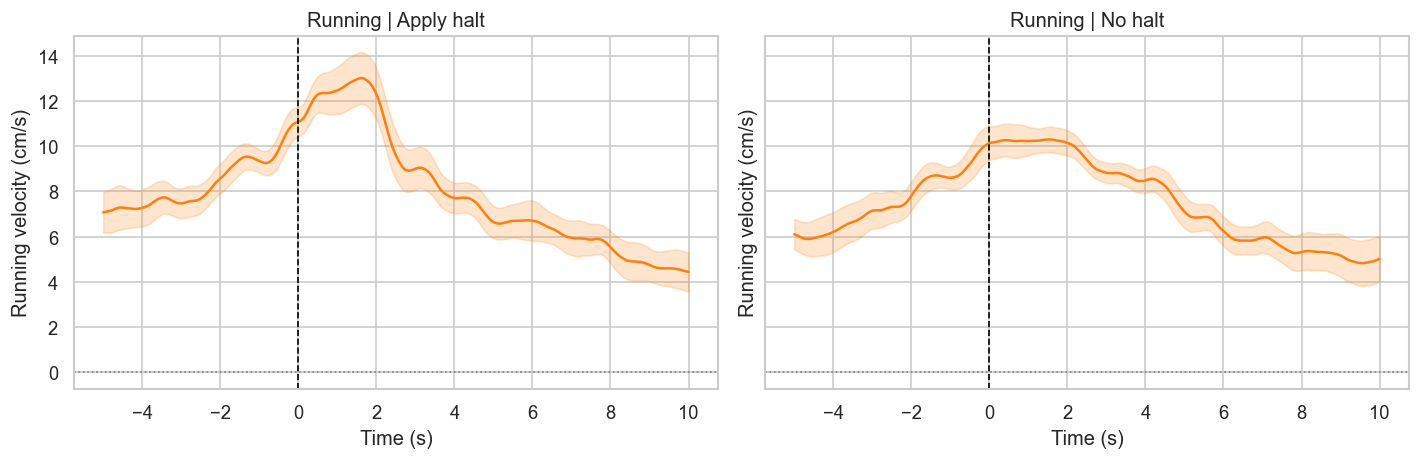

In [12]:
if running_avg_traces.empty:
    print("⚠️ Skipping running trace plots because no averaged traces are available.")
else:
    plot_groups = ["Apply halt", "No halt"]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    for ax, group_name in zip(axes, plot_groups):
        subset = running_avg_traces[running_avg_traces["group"] == group_name]
        if subset.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.axis("off")
            continue

        ax.plot(subset["time"], subset["mean_velocity"], color="#ff7f0e", linewidth=1.5)
        if "sem_velocity" in subset.columns:
            upper = subset["mean_velocity"] + subset["sem_velocity"].fillna(0)
            lower = subset["mean_velocity"] - subset["sem_velocity"].fillna(0)
            ax.fill_between(subset["time"], lower, upper, color="#ff7f0e", alpha=0.2)

        ax.axvline(0, color="black", linestyle="--", linewidth=1)
        ax.axhline(0, color="grey", linestyle=":", linewidth=1)
        ax.set_title(f"Running | {group_name}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Running velocity (cm/s)")

    plt.tight_layout()
    plt.show()

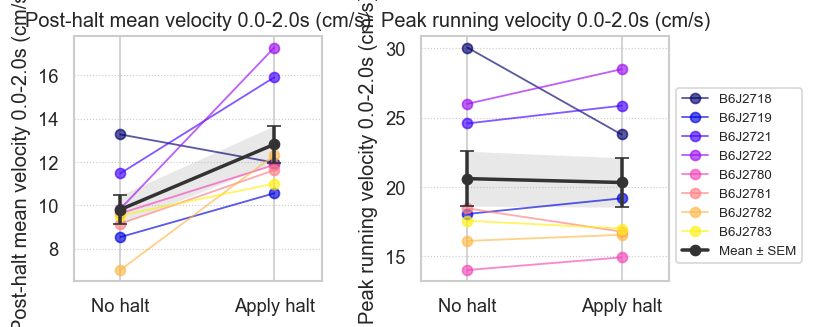

#### Running metrics paired t-tests

,n_pairs,mean_difference,t_statistic,p_value,metric,metric_label,group_a,group_b
0,8,3.009565,3.195161,0.015167,post_mean,Post-halt mean velocity 0.0-2.0s (cm/s),No halt,Apply halt
1,8,-0.279375,-0.290249,0.780036,peak_velocity_abs_1s,Peak running velocity 0.0-2.0s (cm/s),No halt,Apply halt


In [13]:
# Running velocity comparisons (Apply halt vs No halt)
# ----------------------------------------------------------------------

running_metric_specs = [
    ("post_mean", f"Post-halt mean velocity {ANALYSIS_WINDOW_MEAN_PEAK[0]}-{ANALYSIS_WINDOW_MEAN_PEAK[1]}s (cm/s)"),
    ("peak_velocity_abs_1s", f"Peak running velocity {ANALYSIS_WINDOW_MEAN_PEAK[0]}-{ANALYSIS_WINDOW_MEAN_PEAK[1]}s (cm/s)"),
]
running_plot_groups = ["No halt", "Apply halt"]
running_stats_df = pd.DataFrame()

if running_metrics_combined.empty:
    print("⚠️ No per-mouse running velocity metrics available for comparison")
else:
    running_mouse_colors = assign_mouse_colors_consistent(running_metrics_combined["mouse"].dropna().unique())
    available_running_specs = [
        (metric, label)
        for metric, label in running_metric_specs
        if metric in running_metrics_combined.columns
    ]

    if not available_running_specs:
        print("⚠️ Running metrics not found in aggregated data")
    else:
        subplot_width_cm = 7.5
        subplot_height_cm = 7
        fig_width = len(available_running_specs) * subplot_width_cm / 2.54
        fig_height = subplot_height_cm / 2.54
        fig, axes = plt.subplots(
            1,
            len(available_running_specs),
            figsize=(fig_width, fig_height),
            sharey=False,
        )
        if len(available_running_specs) == 1:
            axes = [axes]

        mean_handles = []
        running_mouse_handles: Dict[str, object] = {}
        running_stats_records: List[Dict[str, object]] = []

        for ax, (metric, label) in zip(axes, available_running_specs):
            pivot = running_metrics_combined.pivot(index="mouse", columns="group", values=metric)
            groups_present = [group for group in running_plot_groups if group in pivot.columns]
            if len(groups_present) < 2:
                ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center")
                ax.axis("off")
                continue

            group_a, group_b = groups_present[0], groups_present[1]
            stats_result = compute_paired_t_test(pivot, group_a, group_b)
            stats_result.update(
                {
                    "metric": metric,
                    "metric_label": label,
                    "group_a": group_a,
                    "group_b": group_b,
                }
            )
            running_stats_records.append(stats_result)

            x_positions = np.arange(len(groups_present), dtype=float)

            for mouse in pivot.index:
                values = pivot.loc[mouse, groups_present]
                if values.isna().all():
                    continue
                line, = ax.plot(
                    x_positions,
                    values.to_numpy(dtype=float),
                    marker="o",
                    linewidth=1.1,
                    alpha=0.65,
                    color=running_mouse_colors.get(mouse, "#1f77b4"),
                    zorder=2,
                )
                running_mouse_handles.setdefault(mouse, line)

            group_means = pivot[groups_present].mean(axis=0)
            group_sems = pivot[groups_present].apply(lambda col: sem(col.dropna()), axis=0)
            mean_values = group_means.to_numpy(dtype=float)
            sem_values = group_sems.to_numpy(dtype=float)
            valid_mask = np.isfinite(mean_values) & np.isfinite(sem_values)
            if valid_mask.any():
                x_valid = x_positions[valid_mask]
                mean_valid = mean_values[valid_mask]
                sem_valid = sem_values[valid_mask]
                ax.fill_between(
                    x_valid,
                    mean_valid - sem_valid,
                    mean_valid + sem_valid,
                    color="#b3b3b3",
                    alpha=0.3,
                    zorder=1,
                    linewidth=0,
                )

            error_container = ax.errorbar(
                x_positions,
                mean_values,
                yerr=sem_values,
                fmt="o-",
                color="#333333",
                linewidth=2.1,
                capsize=4,
                label="Mean ± SEM",
                zorder=3,
            )
            mean_handles.append(error_container)

            ax.set_xticks(x_positions)
            ax.set_xticklabels(groups_present)
            ax.set_xlim(-0.3, len(groups_present) - 1 + 0.31)
            ax.set_title(label)
            ax.set_ylabel(label)
            ax.grid(True, which="both", axis="y", linestyle=":", linewidth=0.7)

        legend_handles = list(running_mouse_handles.values())
        legend_labels = list(running_mouse_handles.keys())
        if mean_handles:
            legend_handles.append(mean_handles[0].lines[0])
            legend_labels.append("Mean ± SEM")
        if legend_handles:
            fig.legend(
                legend_handles,
                legend_labels,
                loc="center left",
                bbox_to_anchor=(0.85, 0.5),
                borderaxespad=0.0,
                frameon=True,
                fontsize=8,
            )

        fig.subplots_adjust(left=0, right=0.84, bottom=0.18, top=0.92, wspace=0.4)
        if OUTPUT_DIR is not None:
            fig.savefig(OUTPUT_DIR / "running_metric_comparisons.pdf", format="pdf", bbox_inches="tight")
        plt.show()
        plt.close(fig)

        if running_stats_records:
            running_stats_df = pd.DataFrame(running_stats_records)
            display(Markdown("#### Running metrics paired t-tests"))
            display(running_stats_df)
            if OUTPUT_DIR is not None:
                running_stats_df.to_csv(OUTPUT_DIR / "running_metrics_ttests.csv", index=False)
        else:
            running_stats_df = pd.DataFrame()

### Turning velocity summary


In [14]:
# TURNING Summary statistics
# ----------------------------------------------------------------------

summary_df = summarise_results(results_df)
if summary_df.empty:
    print("⚠️ No summary statistics available")
else:
    for group_name, subdf in summary_df.groupby("group", dropna=False):
        title = group_name if isinstance(group_name, str) else "Unknown"
        display(Markdown(f"### {title}"))
        display(subdf.drop(columns=["group"], errors="ignore").reset_index(drop=True))

### Apply halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,left,1,8,8,-4.816633,0.125
1,right,-1,8,8,4.882097,0.125


### No halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,left,1,7,7,-7.437714,0.000
1,right,-1,8,8,7.025013,0.125


In [15]:
# Turn timing and magnitude metrics
# ----------------------------------------------------------------------

if results_df.empty:
    timing_summary_df = pd.DataFrame()
    timing_mouse_df = pd.DataFrame()
else:
    timing_columns = [
        "time_to_peak",
        "latency_to_fraction_peak",
        "peak_velocity_magnitude",
        "peak_velocity_abs_1s",
        "auc_abs",
        "decay_tau",
    ]
    timing_columns = [column for column in timing_columns if column in results_df.columns]
    if timing_columns:
        timing_summary_df = (
            results_df.groupby(["group", "direction"], dropna=False)[timing_columns]
            .agg(["mean", "sem"])
        )
        timing_summary_df.columns = [f"{metric}_{stat}" for metric, stat in timing_summary_df.columns]
        timing_summary_df = timing_summary_df.reset_index()

        timing_mouse_df = (
            results_df.groupby(["group", "mouse", "direction"], dropna=False)[timing_columns]
            .mean()
            .reset_index()
        )
    else:
        timing_summary_df = pd.DataFrame()
        timing_mouse_df = pd.DataFrame()

timing_summary_df



,group,direction,time_to_peak_mean,time_to_peak_sem,latency_to_fraction_peak_mean,latency_to_fraction_peak_sem,peak_velocity_magnitude_mean,peak_velocity_magnitude_sem,peak_velocity_abs_1s_mean,peak_velocity_abs_1s_sem,auc_abs_mean,auc_abs_sem,decay_tau_mean,decay_tau_sem
0,Apply halt,left,0.761625,0.301074,0.061213,0.061213,17.663150,3.100776,17.663150,3.100776,15.090531,2.358367,8.676966,4.494906
1,Apply halt,right,0.615750,0.204366,0.064250,0.064250,20.099475,2.397874,20.099475,2.397874,15.514437,1.456707,9.390110,5.784763
2,No halt,left,1.041857,0.260211,0.237143,0.215483,21.868214,1.850501,21.868214,1.850501,19.003645,1.500231,8.285259,5.541490
3,No halt,right,0.501250,0.156108,0.000000,0.000000,21.451675,2.244517,21.451675,2.244517,17.661941,2.359871,11.453818,6.000181


In [16]:
if timing_summary_df.empty:
    print("⚠️ No timing metrics available")
else:
    for group_name, subset in timing_summary_df.groupby("group", dropna=False):
        title = group_name if isinstance(group_name, str) else "Unknown"
        display(Markdown(f"### Turn timing | {title}"))
        display(subset.drop(columns=["group"], errors="ignore").reset_index(drop=True))



### Turn timing | Apply halt

,direction,time_to_peak_mean,time_to_peak_sem,latency_to_fraction_peak_mean,latency_to_fraction_peak_sem,peak_velocity_magnitude_mean,peak_velocity_magnitude_sem,peak_velocity_abs_1s_mean,peak_velocity_abs_1s_sem,auc_abs_mean,auc_abs_sem,decay_tau_mean,decay_tau_sem
0,left,0.761625,0.301074,0.061213,0.061213,17.663150,3.100776,17.663150,3.100776,15.090531,2.358367,8.676966,4.494906
1,right,0.615750,0.204366,0.064250,0.064250,20.099475,2.397874,20.099475,2.397874,15.514437,1.456707,9.390110,5.784763


### Turn timing | No halt

,direction,time_to_peak_mean,time_to_peak_sem,latency_to_fraction_peak_mean,latency_to_fraction_peak_sem,peak_velocity_magnitude_mean,peak_velocity_magnitude_sem,peak_velocity_abs_1s_mean,peak_velocity_abs_1s_sem,auc_abs_mean,auc_abs_sem,decay_tau_mean,decay_tau_sem
0,left,1.041857,0.260211,0.237143,0.215483,21.868214,1.850501,21.868214,1.850501,19.003645,1.500231,8.285259,5.541490
1,right,0.501250,0.156108,0.000000,0.000000,21.451675,2.244517,21.451675,2.244517,17.661941,2.359871,11.453818,6.000181


In [17]:
# Compute mean absolute velocity 0-2s (for combining left and right turns)
# ----------------------------------------------------------------------

if trace_samples_df.empty:
    mean_abs_velocity_by_mouse = pd.DataFrame()
else:
    mean_abs_records = []
    
    for (group, mouse), group_df in trace_samples_df.groupby(["group", "mouse"]):
        window_mask = (group_df["time"] >= EXTENDED_RESPONSE_WINDOW[0]) & (group_df["time"] <= EXTENDED_RESPONSE_WINDOW[1])
        window_df = group_df.loc[window_mask].copy()
        
        if not window_df.empty:
            mean_abs_vel = float(window_df["velocity"].abs().mean())
            mean_abs_records.append({
                "group": group,
                "mouse": mouse,
                "mean_abs_velocity_0_2s": mean_abs_vel,
            })
    
    mean_abs_velocity_by_mouse = pd.DataFrame(mean_abs_records)

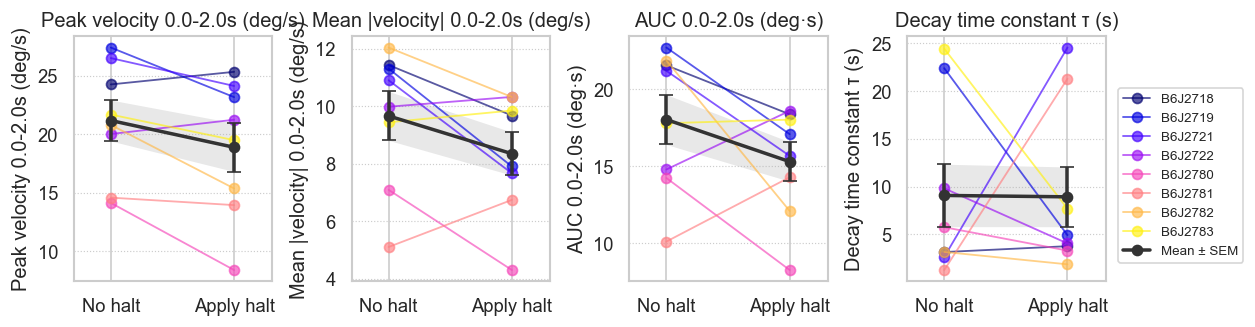

#### Turning metrics paired t-tests

,n_pairs,mean_difference,t_statistic,p_value,metric,metric_label,group_a,group_b
0,8,-2.294331,-2.376919,0.049104,peak_velocity_abs_1s,Peak velocity 0.0-2.0s (deg/s),No halt,Apply halt
1,8,-1.315983,-1.966188,0.089995,mean_abs_velocity_0_2s,Mean |velocity| 0.0-2.0s (deg/s),No halt,Apply halt
2,8,-2.732408,-1.542067,0.166961,auc_abs,AUC 0.0-2.0s (deg·s),No halt,Apply halt
3,8,-0.146894,-0.028300,0.978213,decay_tau,Decay time constant τ (s),No halt,Apply halt


In [18]:
# Turning metric comparisons in a single figure (Apply halt vs No halt)
# ----------------------------------------------------------------------

metric_specs = [
    ("peak_velocity_abs_1s", f"Peak velocity {ANALYSIS_WINDOW_MEAN_PEAK[0]}-{ANALYSIS_WINDOW_MEAN_PEAK[1]}s (deg/s)"),
    ("mean_abs_velocity_0_2s", f"Mean |velocity| {EXTENDED_RESPONSE_WINDOW[0]}-{EXTENDED_RESPONSE_WINDOW[1]}s (deg/s)"),
    ("auc_abs", f"AUC {ANALYSIS_WINDOW_MEAN_PEAK[0]}-{ANALYSIS_WINDOW_MEAN_PEAK[1]}s (deg·s)"),
    ("decay_tau", "Decay time constant τ (s)"),
]
plot_groups = ["No halt", "Apply halt"]
turning_stats_df = pd.DataFrame()

# Aggregate timing metrics directly from results_df
if results_df.empty:
    combined = pd.DataFrame()
else:
    metric_columns = [metric for metric, _ in metric_specs if metric in results_df.columns]
    if metric_columns:
        combined = (
            results_df.groupby(["mouse", "group"], dropna=False)[metric_columns]
            .mean()
            .reset_index()
        )
    else:
        combined = pd.DataFrame()
    
    # Merge in mean absolute velocity 0-2s
    if not mean_abs_velocity_by_mouse.empty and not combined.empty:
        combined = pd.merge(
            combined,
            mean_abs_velocity_by_mouse,
            on=["mouse", "group"],
            how="outer",
        )
    elif not mean_abs_velocity_by_mouse.empty:
        combined = mean_abs_velocity_by_mouse.copy()

if combined.empty:
    print("⚠️ No turning metrics available for comparison")
else:
    available_specs = [(metric, label) for metric, label in metric_specs if metric in combined.columns]
    if not available_specs:
        print("⚠️ Metrics not found in aggregated data")
    else:
        subplot_width_cm = 6.5
        subplot_height_cm = 7
        fig_width = len(available_specs) * subplot_width_cm / 2.54
        fig_height = subplot_height_cm / 2.54
        fig, axes = plt.subplots(1, len(available_specs), figsize=(fig_width, fig_height), sharey=False)
        if len(available_specs) == 1:
            axes = [axes]

        mouse_colors = assign_mouse_colors_consistent(combined["mouse"].dropna().unique())
        mean_handles = []
        mouse_handles: Dict[str, object] = {}
        turning_stats_records: List[Dict[str, object]] = []

        for ax, (metric, label) in zip(axes, available_specs):
            pivot = combined.pivot(index="mouse", columns="group", values=metric)
            groups_present = [group for group in plot_groups if group in pivot.columns]
            if len(groups_present) < 2:
                ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center")
                ax.axis("off")
                continue

            group_a, group_b = groups_present[0], groups_present[1]
            stats_result = compute_paired_t_test(pivot, group_a, group_b)
            stats_result.update(
                {
                    "metric": metric,
                    "metric_label": label,
                    "group_a": group_a,
                    "group_b": group_b,
                }
            )
            turning_stats_records.append(stats_result)

            x_positions = np.arange(len(groups_present))

            for mouse in pivot.index:
                values = pivot.loc[mouse, groups_present]
                if values.isna().all():
                    continue
                valid_mask = values.notna()
                if not valid_mask.any():
                    continue
                x_mouse = x_positions[valid_mask.to_numpy(dtype=bool)]
                y_mouse = values[valid_mask].to_numpy(dtype=float)
                color = mouse_colors.get(mouse, "#1f77b4")
                if x_mouse.size == 1:
                    line, = ax.plot(
                        x_mouse,
                        y_mouse,
                        marker="o",
                        linestyle="none",
                        markersize=5,
                        alpha=0.8,
                        color=color,
                        zorder=2,
                    )
                else:
                    line, = ax.plot(
                        x_mouse,
                        y_mouse,
                        marker="o",
                        linewidth=1.1,
                        alpha=0.65,
                        color=color,
                        zorder=2,
                    )
                mouse_handles.setdefault(mouse, line)

            group_means = pivot[groups_present].mean(axis=0)
            group_sems = pivot[groups_present].apply(lambda col: sem(col.dropna()), axis=0)
            mean_values = group_means.to_numpy(dtype=float)
            sem_values = group_sems.to_numpy(dtype=float)
            valid_mask = np.isfinite(mean_values) & np.isfinite(sem_values)
            if valid_mask.any():
                x_valid = x_positions[valid_mask]
                mean_valid = mean_values[valid_mask]
                sem_valid = sem_values[valid_mask]
                ax.fill_between(
                    x_valid,
                    mean_valid - sem_valid,
                    mean_valid + sem_valid,
                    color="#b3b3b3",
                    alpha=0.3,
                    zorder=1,
                    linewidth=0,
                )

            error_container = ax.errorbar(
                x_positions,
                mean_values,
                yerr=sem_values,
                fmt="o-",
                color="#333333",
                linewidth=2.1,
                capsize=4,
                label="Mean ± SEM",
                zorder=3,
            )
            mean_handles.append(error_container)

            ax.set_xticks(x_positions)
            ax.set_xticklabels(groups_present)
            ax.set_xlim(-0.3, len(groups_present) - 1 + 0.31)
            ax.set_title(label)
            ax.set_ylabel(label)
            ax.grid(True, which="both", axis="y", linestyle=":", linewidth=0.7)

        legend_handles = list(mouse_handles.values())
        legend_labels = list(mouse_handles.keys())
        if mean_handles:
            legend_handles.append(mean_handles[0].lines[0])
            legend_labels.append("Mean ± SEM")
        if legend_handles:
            fig.legend(
                legend_handles,
                legend_labels,
                loc="center left",
                bbox_to_anchor=(0.85, 0.5),
                borderaxespad=0.0,
                frameon=True,
                fontsize=8,
            )

        fig.subplots_adjust(left=0, right=0.84, bottom=0.18, top=0.92, wspace=0.4)
        if OUTPUT_DIR is not None:
            fig.savefig(OUTPUT_DIR / "turning_metric_comparisons.pdf", format="pdf", bbox_inches="tight")
        plt.show()
        plt.close(fig)

        if turning_stats_records:
            turning_stats_df = pd.DataFrame(turning_stats_records)
            display(Markdown("#### Turning metrics paired t-tests"))
            display(turning_stats_df)
            if OUTPUT_DIR is not None:
                turning_stats_df.to_csv(OUTPUT_DIR / "turning_metrics_ttests.csv", index=False)

In [19]:
# Average motor velocity traces by condition and turn direction
# ----------------------------------------------------------------------

if trace_samples_df.empty:
    per_mouse_traces = pd.DataFrame()
    avg_traces = pd.DataFrame()
else:
    per_mouse_traces = (
        trace_samples_df
        .groupby(["group", "direction", "mouse", "time"], dropna=False)["velocity"]
        .mean()
        .reset_index()
    )
    avg_traces = (
        per_mouse_traces
        .groupby(["group", "direction", "time"], dropna=False)
        .agg(
            mean_velocity=("velocity", "mean"),
            sem_velocity=("velocity", lambda x: sem(x) if len(x.dropna()) > 1 else 0.0),
            n_mice=("mouse", "nunique"),
        )
        .reset_index()
    )

avg_traces

,group,direction,time,mean_velocity,sem_velocity,n_mice
0,Apply halt,left,-5.000,0.568349,1.557513,8
1,Apply halt,left,-4.999,0.565644,1.556521,8
2,Apply halt,left,-4.998,0.562961,1.555530,8
3,Apply halt,left,-4.997,0.560271,1.554535,8
4,Apply halt,left,-4.996,0.557584,1.553535,8
...,...,...,...,...,...,...
59999,No halt,right,9.996,0.936539,0.786563,8
60000,No halt,right,9.997,0.937711,0.786926,8
60001,No halt,right,9.998,0.938882,0.787286,8
60002,No halt,right,9.999,0.940056,0.787640,8


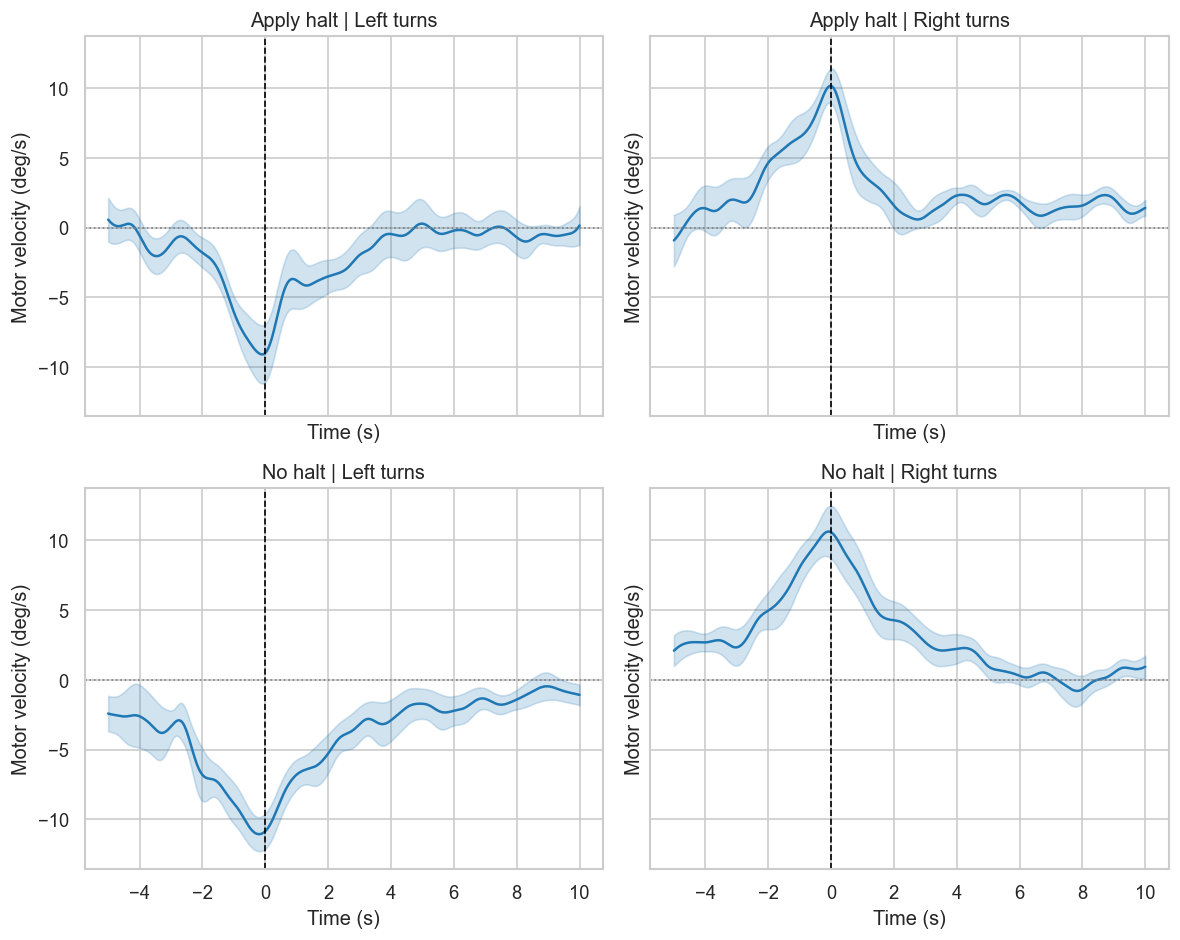

In [20]:
# 2x2 average motor velocity figure (Apply halt / No halt x Left / Right)
# ----------------------------------------------------------------------

if avg_traces.empty:
    print("⚠️ No averaged traces available for plotting")
else:
    plot_order = [
        ("Apply halt", "left"),
        ("Apply halt", "right"),
        ("No halt", "left"),
        ("No halt", "right"),
    ]
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, (group_name, direction) in zip(axes, plot_order):
        subset = avg_traces[
            (avg_traces["group"] == group_name)
            & (avg_traces["direction"] == direction)
        ]
        if subset.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.axis("off")
            continue

        ax.plot(subset["time"], subset["mean_velocity"], color="#1f77b4", linewidth=1.5)
        if "sem_velocity" in subset.columns:
            upper = subset["mean_velocity"] + subset["sem_velocity"].fillna(0)
            lower = subset["mean_velocity"] - subset["sem_velocity"].fillna(0)
            ax.fill_between(subset["time"], lower, upper, color="#1f77b4", alpha=0.2)

        ax.axvline(0, color="black", linestyle="--", linewidth=1)
        ax.axhline(0, color="grey", linestyle=":", linewidth=1)
        ax.set_title(f"{group_name} | {direction.capitalize()} turns")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Motor velocity (deg/s)")

    plt.tight_layout()
    plt.show()

### Alternative temporal dynamics analysis (better than decay fitting)

The exponential decay fit often fails because motor velocity shows complex, 
non-exponential dynamics. Better approaches:
1. **Windowed AUC**: Quantify response in different time phases
2. **Sustained response ratio**: Compare early vs late response magnitude  
3. **Time to baseline**: When does response return to pre-turn levels

In [21]:
# Compute alternative temporal metrics for each mouse
# ----------------------------------------------------------------------

if not trace_samples_df.empty:
    print("Computing alternative temporal dynamics metrics...")
    
    # Define time windows for AUC analysis
    AUC_WINDOWS = [
        (0.0, 0.5),   # Early response
        (0.5, 1.0),   # Mid response  
        (1.0, 2.0),   # Late response
        (0.0, 2.0),   # Total response
    ]
    
    alternative_metrics_records = []
    
    for (group, mouse, direction), group_df in trace_samples_df.groupby(["group", "mouse", "direction"]):
        # Compute windowed AUC
        auc_metrics = compute_windowed_auc(group_df, AUC_WINDOWS)
        
        # Compute sustained response ratio
        sustained_ratio = compute_sustained_response_ratio(group_df)
        
        # Compute time to baseline
        time_to_baseline = compute_time_to_baseline(group_df)
        
        # Compile all metrics
        alternative_metrics_records.append({
            "group": group,
            "mouse": mouse,
            "direction": direction,
            **auc_metrics,
            "sustained_ratio": sustained_ratio,
            "time_to_baseline": time_to_baseline,
        })
    
    alternative_metrics_df = pd.DataFrame(alternative_metrics_records)
    
    # Average across turn directions per mouse
    alt_metrics_by_mouse = (
        alternative_metrics_df.groupby(["group", "mouse"], dropna=False)
        .mean(numeric_only=True)
        .reset_index()
    )
    
    print(f"✅ Computed alternative metrics for {len(alt_metrics_by_mouse)} mouse-group combinations")
    display(Markdown("#### Alternative temporal dynamics metrics (per mouse)"))
    display(alt_metrics_by_mouse)
    
    if OUTPUT_DIR is not None:
        alt_metrics_by_mouse.to_csv(OUTPUT_DIR / "alternative_temporal_metrics.csv", index=False)
else:
    alternative_metrics_df = pd.DataFrame()
    alt_metrics_by_mouse = pd.DataFrame()
    print("⚠️ No trace data available for alternative metrics")

Computing alternative temporal dynamics metrics...
✅ Computed alternative metrics for 16 mouse-group combinations


#### Alternative temporal dynamics metrics (per mouse)

,group,mouse,auc_0.0_0.5s,auc_0.5_1.0s,auc_1.0_2.0s,auc_0.0_2.0s,sustained_ratio,time_to_baseline
0,Apply halt,B6J2718,5.973276,4.706465,7.698060,18.377801,0.499625,0.0000
1,Apply halt,B6J2719,5.320240,4.786851,6.978025,17.085116,0.312107,0.0045
2,Apply halt,B6J2721,5.515533,3.791533,6.368284,15.675351,0.303624,0.0005
3,Apply halt,B6J2722,5.443832,4.866680,8.293531,18.604043,0.368979,0.0000
4,Apply halt,B6J2780,1.731598,2.712689,3.815312,8.259599,1.085828,0.0000
5,Apply halt,B6J2781,3.958133,4.333686,5.997806,14.289624,0.676587,0.0000
6,Apply halt,B6J2782,4.722921,3.675680,3.698182,12.096783,0.362033,0.0000
7,Apply halt,B6J2783,4.757820,3.996434,9.277300,18.031554,1.192193,0.0005
8,No halt,B6J2718,7.031300,5.938471,8.587004,21.556775,0.493270,0.0160
9,No halt,B6J2719,6.833262,6.119515,9.760453,22.713230,0.431313,0.0090


In [22]:
# Statistical comparison of alternative metrics: Apply halt vs No halt
# ----------------------------------------------------------------------

if not alt_metrics_by_mouse.empty:
    print("\n" + "="*60)
    print("STATISTICAL COMPARISON: Apply halt vs No halt")
    print("="*60)
    
    # Define metrics to compare
    alt_metrics_to_compare = [
        ("auc_0.0_0.5s", "Early AUC 0-0.5s (deg)"),
        ("auc_0.5_1.0s", "Mid AUC 0.5-1s (deg)"),
        ("auc_1.0_2.0s", "Late AUC 1-2s (deg)"),
        ("auc_0.0_2.0s", "Total AUC 0-2s (deg)"),
        ("sustained_ratio", "Sustained response ratio (late/early)"),
        ("time_to_baseline", "Time to baseline (s)"),
    ]
    
    alt_stats_records = []
    
    for metric, label in alt_metrics_to_compare:
        if metric not in alt_metrics_by_mouse.columns:
            continue
        
        # Create pivot table
        pivot = alt_metrics_by_mouse.pivot(index="mouse", columns="group", values=metric)
        
        if "No halt" in pivot.columns and "Apply halt" in pivot.columns:
            stats_result = compute_paired_t_test(pivot, "No halt", "Apply halt")
            
            # Add descriptive statistics
            no_halt_vals = pivot["No halt"].dropna()
            apply_halt_vals = pivot["Apply halt"].dropna()
            
            stats_result.update({
                "metric": metric,
                "metric_label": label,
                "no_halt_mean": float(no_halt_vals.mean()) if len(no_halt_vals) > 0 else float("nan"),
                "no_halt_sem": float(sem(no_halt_vals)) if len(no_halt_vals) > 1 else float("nan"),
                "apply_halt_mean": float(apply_halt_vals.mean()) if len(apply_halt_vals) > 0 else float("nan"),
                "apply_halt_sem": float(sem(apply_halt_vals)) if len(apply_halt_vals) > 1 else float("nan"),
            })
            
            alt_stats_records.append(stats_result)
    
    if alt_stats_records:
        alt_stats_df = pd.DataFrame(alt_stats_records)
        
        # Reorder columns for clarity
        col_order = [
            "metric_label", 
            "no_halt_mean", "no_halt_sem",
            "apply_halt_mean", "apply_halt_sem",
            "mean_difference", "t_statistic", "p_value", "n_pairs"
        ]
        alt_stats_df = alt_stats_df[[col for col in col_order if col in alt_stats_df.columns]]
        
        display(Markdown("#### Paired t-tests for alternative temporal metrics"))
        display(alt_stats_df)
        
        if OUTPUT_DIR is not None:
            alt_stats_df.to_csv(OUTPUT_DIR / "alternative_metrics_ttests.csv", index=False)
        
        # Highlight significant results
        if "p_value" in alt_stats_df.columns:
            sig_results = alt_stats_df[alt_stats_df["p_value"] < 0.05]
            if not sig_results.empty:
                display(Markdown("#### Significant differences (p < 0.05)"))
                display(sig_results)
    else:
        alt_stats_df = pd.DataFrame()
        print("⚠️ Could not perform statistical comparisons")
else:
    alt_stats_df = pd.DataFrame()


STATISTICAL COMPARISON: Apply halt vs No halt


#### Paired t-tests for alternative temporal metrics

,metric_label,no_halt_mean,no_halt_sem,apply_halt_mean,apply_halt_sem,mean_difference,t_statistic,p_value,n_pairs
0,Early AUC 0-0.5s (deg),5.443101,0.557489,4.677919,0.474079,-0.765182,-1.991226,0.086734,8
1,Mid AUC 0.5-1s (deg),4.679416,0.447929,4.108752,0.256763,-0.570663,-1.182359,0.275664,8
2,Late AUC 1-2s (deg),7.912375,0.672780,6.515813,0.706087,-1.396562,-1.468229,0.185488,8
3,Total AUC 0-2s (deg),18.034891,1.618879,15.302484,1.281929,-2.732408,-1.542067,0.166961,8
4,Sustained response ratio (late/early),0.649897,0.074853,0.600122,0.125597,-0.049775,-0.560761,0.592448,8
5,Time to baseline (s),0.003750,0.002092,0.000687,0.000550,-0.003063,-1.553181,0.164324,8


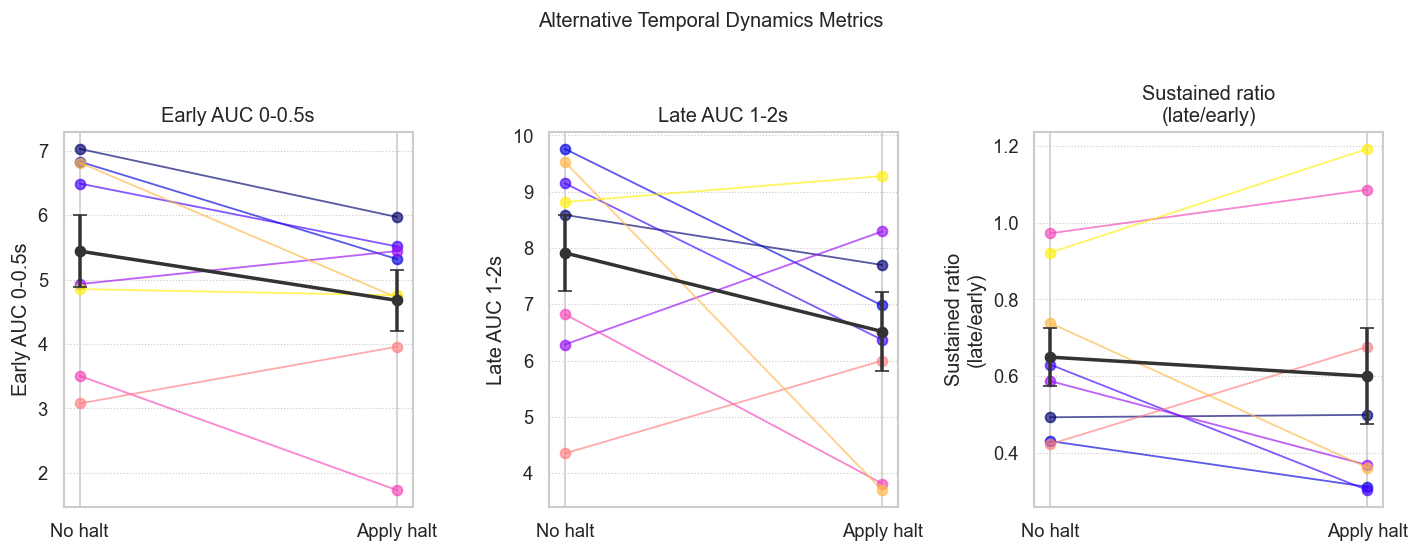

In [23]:
# Visualization: Alternative metrics comparison
# ----------------------------------------------------------------------

if not alt_metrics_by_mouse.empty:
    # Select key metrics to visualize
    viz_metrics = [
        ("auc_0.0_0.5s", "Early AUC 0-0.5s"),
        ("auc_1.0_2.0s", "Late AUC 1-2s"),  
        ("sustained_ratio", "Sustained ratio\n(late/early)"),
    ]
    
    # Filter to metrics that exist
    viz_metrics = [(m, l) for m, l in viz_metrics if m in alt_metrics_by_mouse.columns]
    
    if viz_metrics:
        fig, axes = plt.subplots(1, len(viz_metrics), figsize=(4*len(viz_metrics), 4.5))
        if len(viz_metrics) == 1:
            axes = [axes]
        
        mouse_colors = assign_mouse_colors_consistent(alt_metrics_by_mouse["mouse"].unique())
        
        for ax, (metric, label) in zip(axes, viz_metrics):
            pivot = alt_metrics_by_mouse.pivot(index="mouse", columns="group", values=metric)
            groups_present = [g for g in ["No halt", "Apply halt"] if g in pivot.columns]
            
            if len(groups_present) < 2:
                ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center")
                ax.axis("off")
                continue
            
            x_positions = np.arange(len(groups_present))
            
            # Plot individual mice
            for mouse in pivot.index:
                values = pivot.loc[mouse, groups_present]
                if values.isna().all():
                    continue
                ax.plot(
                    x_positions,
                    values.to_numpy(dtype=float),
                    marker="o",
                    linewidth=1.1,
                    alpha=0.65,
                    color=mouse_colors.get(mouse, "#1f77b4"),
                    zorder=2,
                )
            
            # Plot group means
            group_means = pivot[groups_present].mean(axis=0)
            group_sems = pivot[groups_present].apply(lambda col: sem(col.dropna()), axis=0)
            
            ax.errorbar(
                x_positions,
                group_means.to_numpy(dtype=float),
                yerr=group_sems.to_numpy(dtype=float),
                fmt="o-",
                color="#333333",
                linewidth=2.1,
                capsize=4,
                label="Mean ± SEM",
                zorder=3,
            )
            
            ax.set_xticks(x_positions)
            ax.set_xticklabels(groups_present)
            ax.set_ylabel(label)
            ax.set_title(label)
            ax.grid(True, which="both", axis="y", linestyle=":", linewidth=0.7)
        
        plt.suptitle("Alternative Temporal Dynamics Metrics", fontsize=12, y=1.02)
        plt.tight_layout()
        
        if OUTPUT_DIR is not None:
            fig.savefig(OUTPUT_DIR / "alternative_metrics_comparison.pdf", format="pdf", bbox_inches="tight")
        
        plt.show()
        plt.close(fig)